In [11]:
import os
import tensorflow as tf
import numpy as np
import pydub
import matplotlib.pyplot as plt

# load dataset in tesorflow format :

In [2]:
dataset_path = "./dataset/"

train_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    subset="training",

    # new parameter for AUDIO task
    #طول هرکدوم از دیتاهای صوت مون باید ۴۸هزار باشه ، اما در بخش قبل گفتیم یک ثانیه ای باشند هرکدوم
    output_sequence_length= 48000,

    # دیتاهای ورودی به شبکه طول های متفاوت داشته باشند یا خیر 
    # ragged means data with different length, so we consider it false
    ragged= False, 

    # inferred value, generate labels from the directory structure it self automatically.
    # refers to 'audio_dataset_from_directory' in tensorflow.org
    labels="inferred",
    
    label_mode="categorical",

    # it will raise << tensorflow_io.so >> error , therefore here we dont consider it , and set it to None
    # we will determine sample rate in 'make_dataset' part, and handle it with pydub
    sampling_rate= None,
    seed=59
)


validation_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    subset="validation",

    # new parameter for AUDIO task
    output_sequence_length= 48000,
    ragged= False, 
    labels="inferred",
    label_mode="categorical",
    sampling_rate= None,
    seed=59
)


Found 1770 files belonging to 21 classes.
Using 1416 files for training.
Found 1770 files belonging to 21 classes.
Using 354 files for validation.


seed : <br/>
اگر پارامتر سییید رو تعریف نکنیم ارور میده <br/>
error : ValueError: If using **`validation_split`** and **shuffling** the data, you must provide a `seed` argument, to make sure that there is no overlap between the training and validation subset.
<br/>
علت : <br/>
تا وقتی میخواد ۰.۲ از دیتا هارو بده به ولیدیشن  ، و ۰.۸ هم برای ترین 
اتفاقی یک دیتا هم توی ولیدیشن و هم توی قسمت ترین نره 
و یا یک دیتا نه توی ترین و نه توی ولیدیشن نباشه 
چون بصورت رندوم دارن انتخاب میشن ممکنه این اشکال پیش بیاد
با تعریف سیید ،‌ میگیم که انتخاب داده ها برای پارت های ترین و ولیدیشن کنترل شده میشه و دیگه دیتاها همپوشانی ندارند .

# Creating model :

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(16, kernel_size = 80,strides = 16, activation = "relu", input_shape = (48000, 1)),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Conv1D(16, kernel_size = 3, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Conv1D(16, kernel_size = 3,activation = "relu"),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Conv1D(32, kernel_size = 3,activation = "relu"),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Conv1D(32, kernel_size = 3,activation = "relu"),
    tf.keras.layers.MaxPooling1D(4),

    # chera bayad flat kard mage 1 bodi nistan data ha ?
    # چون وقتی ۳۲ تا فیلتر روی دیتا اعمال میکنیم ،‌ درلایه بعدی بعد مون میشه ۳۲ و دیگه ۱ بعدی نیست 
    # و همینطور در لایه بعدی که ۶۴ تا فیلتر اعمال میکنیم ، ابعادمون میشه ۶۴ ....
    # look at the output shape in below summary 
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(50 , activation="relu"),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(21 , activation="softmax")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 2996, 16)          1296      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 749, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 747, 16)           784       
                                                                 
 batch_normalization_3 (Batc  (None, 747, 16)          64        
 hNormalization)                                                 
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 186, 16)          0         
 g1D)                                                            
                                                      

 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 21)                1365      
                                                                 
Total params: 8,965
Trainable params: 8,933
Non-trainable params: 32
_________________________________________________________________


In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = tf.keras.losses.categorical_crossentropy , 
              metrics="accuracy"
              )

In [20]:
history = model.fit( train_data , validation_data=validation_data , epochs=120)

Epoch 1/120
354/354 [==============================] - 5s 10ms/step - loss: 2.9864 - accuracy: 0.1024 - val_loss: 2.9693 - val_accuracy: 0.1299
Epoch 2/120
354/354 [==============================] - 3s 8ms/step - loss: 2.7767 - accuracy: 0.1229 - val_loss: 2.7202 - val_accuracy: 0.1780
Epoch 3/120
354/354 [==============================] - 3s 8ms/step - loss: 2.6396 - accuracy: 0.1758 - val_loss: 2.5691 - val_accuracy: 0.2203
Epoch 4/120
354/354 [==============================] - 3s 8ms/step - loss: 2.4868 - accuracy: 0.2408 - val_loss: 2.4020 - val_accuracy: 0.2627
Epoch 5/120
354/354 [==============================] - 3s 8ms/step - loss: 2.2935 - accuracy: 0.2973 - val_loss: 2.2088 - val_accuracy: 0.3333
Epoch 6/120
354/354 [==============================] - 3s 8ms/step - loss: 2.0959 - accuracy: 0.3764 - val_loss: 2.0184 - val_accuracy: 0.4096
Epoch 7/120
354/354 [==============================] - 3s 8ms/step - loss: 1.8945 - accuracy: 0.4435 - val_loss: 1.8443 - val_accuracy: 0.460

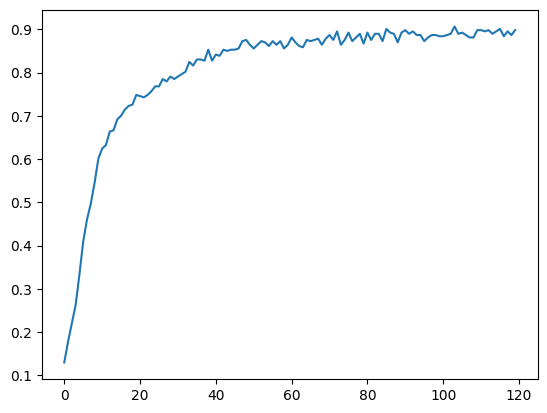

In [21]:
plt.plot(history.history["val_accuracy"])
plt.show()

In [22]:
model.save('audio_classification_model.h5')

## predict data

In [ ]:
test_data = tf.keras.utils.audio_dataset_from_directory(
    "./test/",
    shuffle=False,
    batch_size=4,
    output_sequence_length= 48000,
    ragged= False, 
    labels="inferred",
    label_mode="categorical",
    sampling_rate= None,
    seed=59
)

In [ ]:
classes_labels = np.array(train_data.class_names)
classes_labels

array(['abdollah', 'azra', 'davood', 'javad', 'khadijeh', 'kiana',
       'maryam', 'matin', 'melika', 'mohammad', 'mohammad_parvari',
       'mona', 'nahid', 'nima', 'omid', 'parisa', 'parsa', 'sadegh',
       'sajedeh', 'shima', 'tara'], dtype='<U16')

In [ ]:
model = tf.keras.models.load_model('audio_classification_model.h5')
predictions = model.predict(test_data)
predictions = tf.where(predictions > 0.8,1,0) # اینجا میایم و اون کلاسی که احتمالش از ۰.۸ بیشتره رو ۱ میاریم و بقیه رو صفر 
print('Predictions:\n', predictions.numpy())

1/1 [==============================] - 0s 149ms/step
Predictions:
 [[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
for i,voice in enumerate(predictions):
    
    probability = predictions[i]
    predicted_class_index = np.argmax(probability)

    predicted_class = classes_labels[predicted_class_index]
    accuracy = probability[predicted_class_index]
    print(f'The owner of tested audio is : {predicted_class}')
    print(f'Accuracy: {accuracy}')


The owner of tested audio is : kiana
Accuracy: 1


## explanation of occurred errors :

### 1st error :   
ValueError: Shapes (None, 21) and (None, 64) are incompatible <br/>
عدد ۲۱ تعداد افراد یا کلاس هاست ، ولی تعداد نرون های لایه آخر رو ۶۴ گذاشتیم <br/>


### 2nd error : 
InvalidArgumentError: Graph execution error: Header mismatch: Expected RIFF but found ID3  <br/>
این خطا به دلیل این است که در هنگام ساخت دیتاست فرمت ویو رو براش تعیین نکردیم در خط آخر 
chunk.export(os.path.join("dataset" , person_name , f"voice_{i}.wav" ))
<br/>
solution : <br/>
chunk.export(os.path.join("dataset" , person_name , f"voice_{i}.wav" ) , format="wav")
<br/>

### 3rd-errror : 
converting 32 bit wav file data into 16 bit :
audio = audio.set_sample_width(2) 
yani har sample toolesh 2 byte ya 16 bit beshe 
<br/>

### 4th error : 
صدای ۲ کاناله یا استریو بودن وویس باعث ایجاد این اررو می شود  <br/>
به خاطر چند بعدی بودن فایل صدا یا استریو بودن  
input must be (48000,1) , but some data are (48000, 2) !  <br/>
it's bc of sample rate . <br/>
گفتیم که هر دیتا یک ثانیه است . اما توی همین یک ثانیه ۴۸۰۰۰ تا دیتا با فرکانس های مختلف وجود داره . <br/>
48000 number of data are in 1 second of an audio

+ final codes that added into make_dataset last cell (in class case): <br/>
audio = audio.set_sample_width(2)   
audio = audio.set_frame_rate(48000)  # its like resizing but with that same channels <br/>
audio = audio.set_channels(1) 


### 5th error :
now we should update or delete all files in *dataset folder* , and create them again . 




models for audio task :M3 , M5 , M11 , M18